In [3]:
import json, gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from pathlib import Path

data = Path('data')
pd.set_option('display.max_rows', None)

# Load the json file
with gzip.open(data / 'franchises.json.gz', 'rt') as f:
	franchises = json.load(f)

# Convert the franchises list to a dataframe
df = pd.DataFrame(franchises)

# Show the dataframe
df = df.sort_values(by=['my_score'], ascending=False)
df

,title,episodes,score,my_score,genres,themes,demographics,studios,licensors,producers
42,Mononoke Hime,1,8.670000,10.000000,"[Award Winning, Adventure, Fantasy, Action]",[],[],[Studio Ghibli],[GKIDS],"[Nippon Television Network, Tokuma Shoten]"
25,Howl no Ugoku Shiro,1,8.660000,10.000000,"[Romance, Drama, Award Winning, Fantasy, Adven...",[],[],[Studio Ghibli],[Disney Platform Distribution],"[Tokuma Shoten, d-rights]"
2,"""Oshi no Ko""",11,8.820000,10.000000,"[Supernatural, Drama]","[Showbiz, Reincarnation]",[Seinen],[Doga Kobo],[Sentai Filmworks],"[Shueisha, Kadokawa, CyberAgent]"
35,Kimi wa Houkago Insomnia,13,8.090000,10.000000,[Romance],[School],[Seinen],[LIDENFILMS],[Sentai Filmworks],"[Shogakukan, MAGNET, Pony Canyon, Ultra Super ..."
66,Tenkuu no Shiro Laputa,1,8.260000,10.000000,"[Romance, Award Winning, Fantasy, Adventure, S...",[],[],[Studio Ghibli],"[GKIDS, Disney Platform Distribution]","[Streamline Pictures, Tokuma Shoten]"
65,Tengoku Daimakyou,13,8.230000,10.000000,"[Adventure, Mystery, Sci-Fi]",[Survival],[Seinen],[Production I.G],[],"[Kodansha, NBCUniversal Entertainment Japan, A..."
31,Kaguya-sama wa Kokurasetai?,38,8.709737,10.000000,"[Romance, Comedy, Drama]","[Psychological, Romantic Subtext, School]",[Seinen],[A-1 Pictures],[Aniplex of America],"[Magic Capsule, Aniplex, Shueisha, JR East Mar..."
69,Vinland Saga,50,8.719000,9.940000,"[Adventure, Drama, Action]","[Historical, Gore]",[Seinen],"[Wit Studio, MAPPA]",[Sentai Filmworks],"[Production I.G, Kodansha, Dentsu, Twin Engine]"
47,Nichijou:,27,8.420741,9.925926,[Comedy],"[School, Gag Humor]",[Shounen],[Kyoto Animation],"[Funimation, Bandai Entertainment]","[Movic, Rakuonsha, Animation Do, KlockWorx, La..."
58,Shingeki no Kyojin:,89,8.678876,9.820225,"[Award Winning, Suspense, Drama, Action]","[Survival, Military, Gore]",[Shounen],"[Wit Studio, MAPPA]",[Funimation],"[Dentsu, Pony Canyon Enterprise, Kodansha, Mai..."


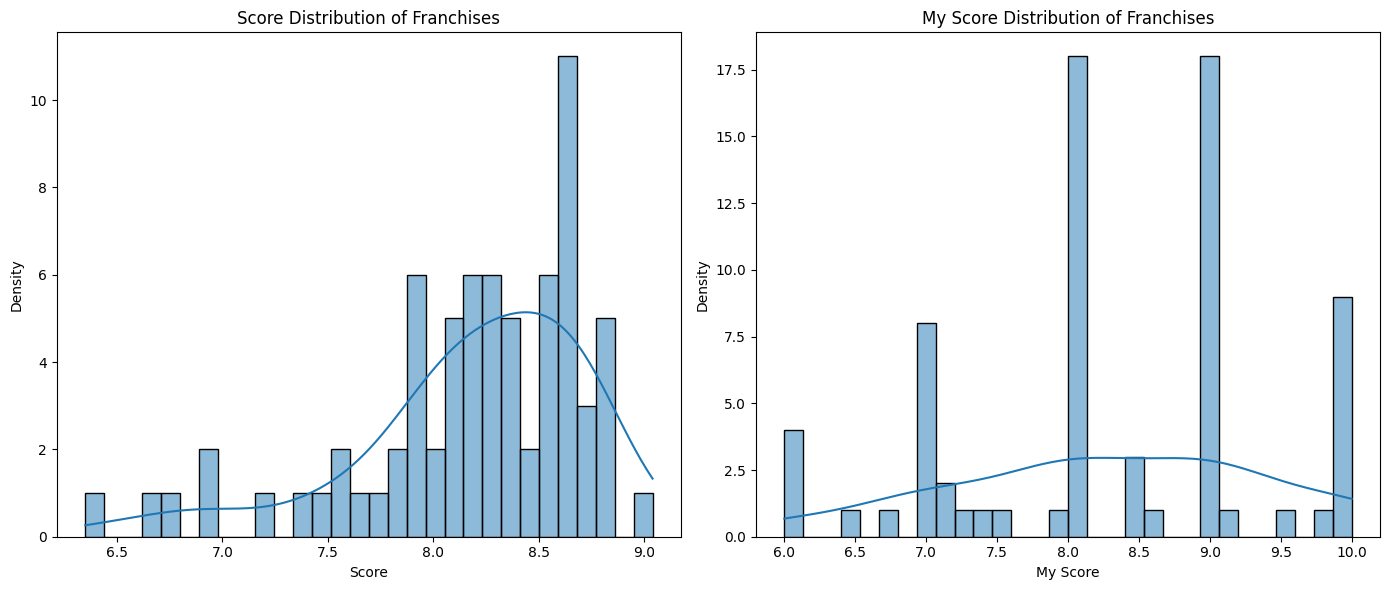

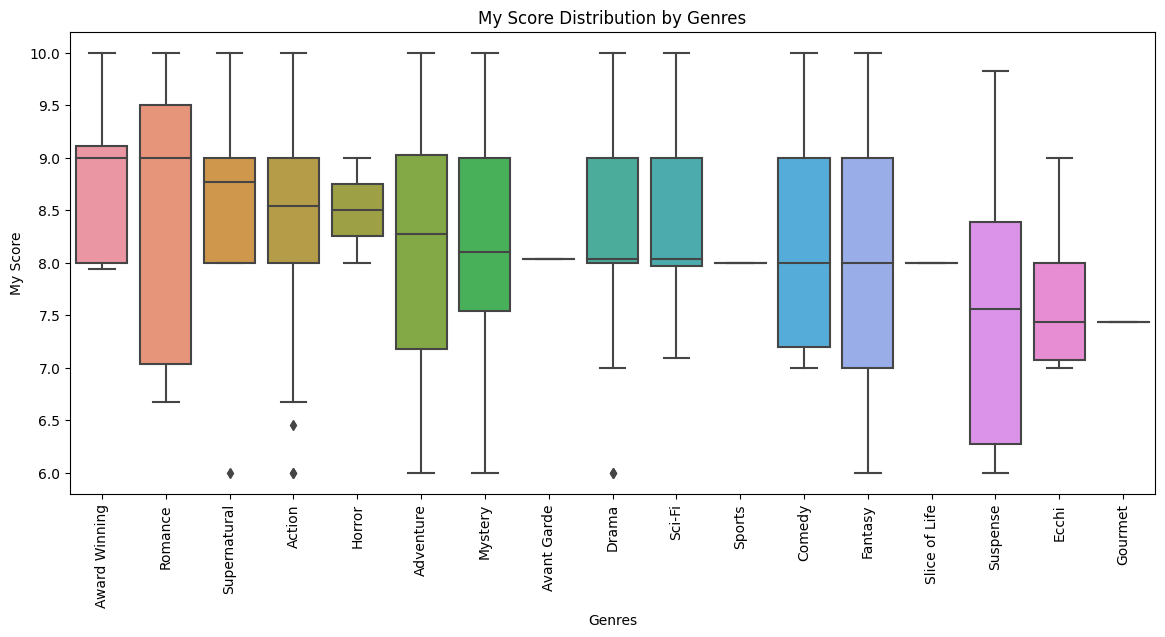

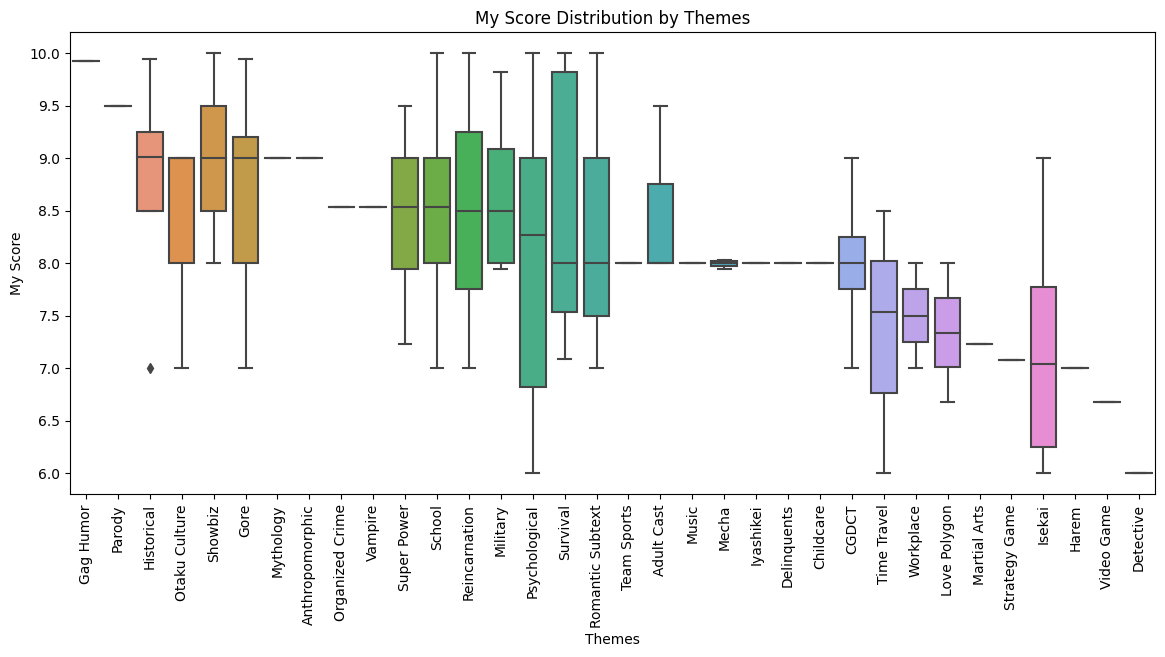

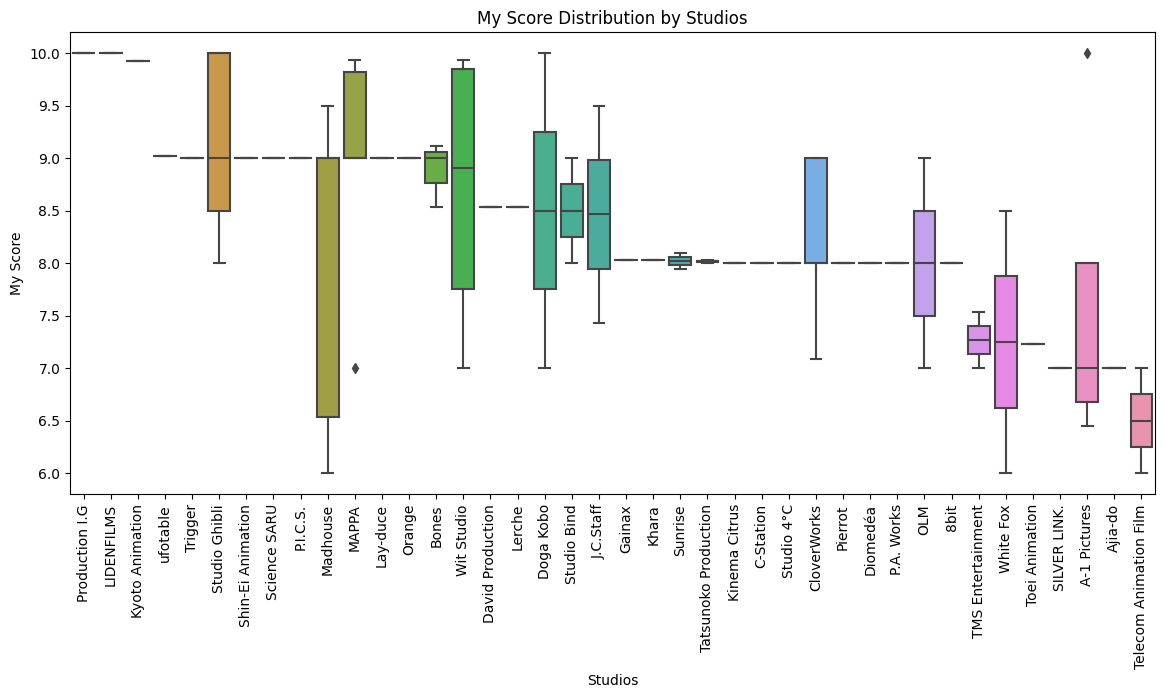

In [4]:
# Remove entries with missing 'score' or 'my_score'
df = df.dropna(subset=['score', 'my_score'])

# Create the figure and subplots for histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histograms of 'score' and 'my_score'
sns.histplot(df['score'], kde=True, bins=30, ax=axs[0])
axs[0].set_title('Score Distribution of Franchises')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Density')

sns.histplot(df['my_score'], kde=True, bins=30, ax=axs[1])
axs[1].set_title('My Score Distribution of Franchises')
axs[1].set_xlabel('My Score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Helper function for generating box plots
def box_plot(data, x, y, title, xlabel, ylabel):
    if data[x].notna().any():  # Check if there are any non-null values
        plt.figure(figsize=(14, 6))
        sns.boxplot(x=x, y=y, data=data, order=order)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=90)
        plt.show()

# Unnest 'genres', 'themes', and 'studios' fields and create box plots
for field in ['genres', 'themes', 'studios']:
    df_unnested = df.explode(field)
    
    # Sort by descending average my_score
    order = df_unnested.groupby(field)['my_score'].median().sort_values(ascending=False).index
    
    box_plot(df_unnested, field, 'my_score', f'My Score Distribution by {field.capitalize()}', field.capitalize(), 'My Score')

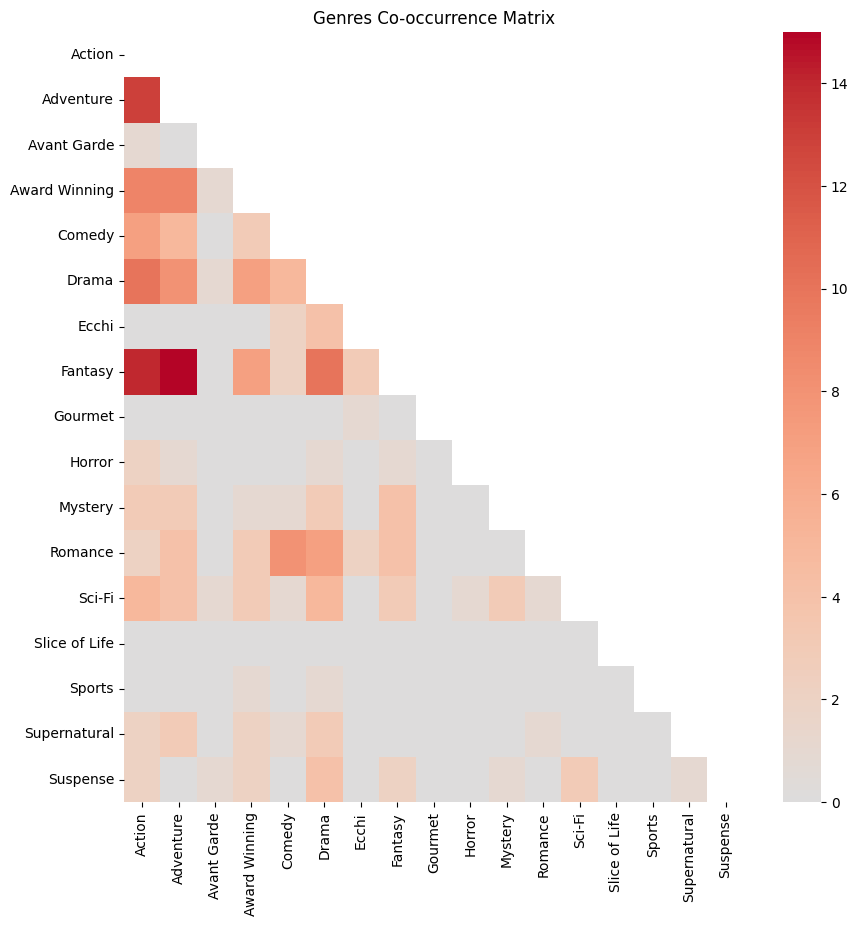

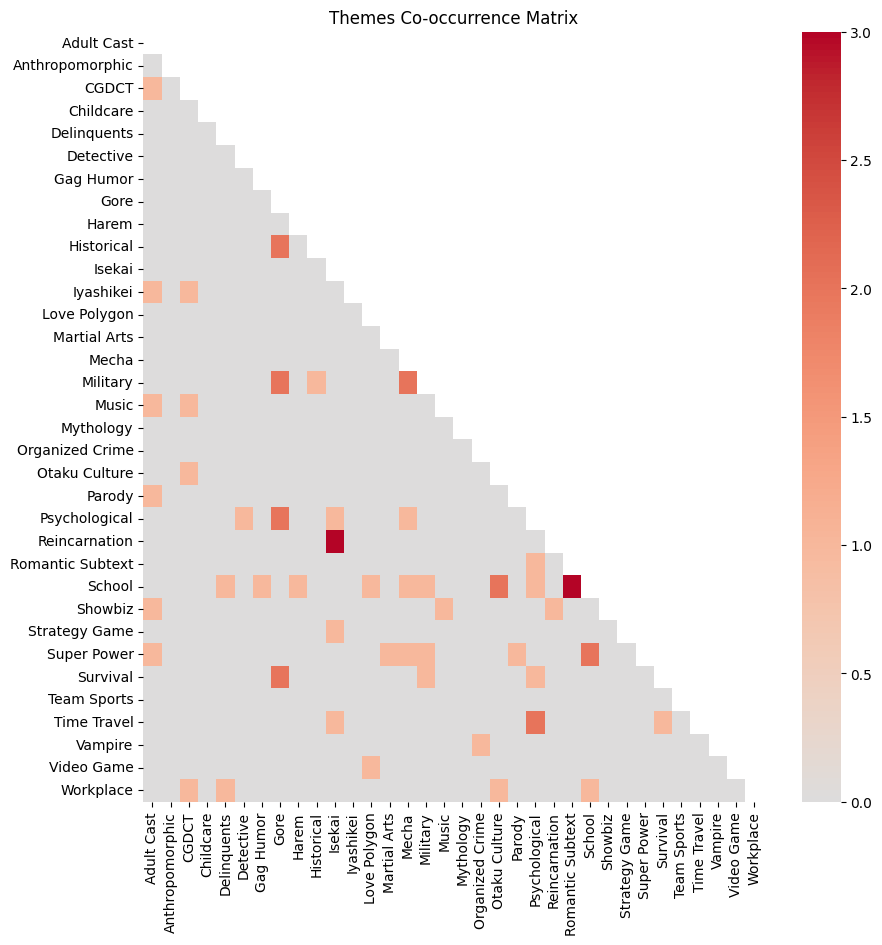

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

def draw_co_occurrence_matrix(data, title):
    """Draw a co-occurrence matrix with a title and masks the upper triangle."""
    co_occurrence_matrix = np.dot(data.transpose(), data)
    co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=data.columns, columns=data.columns)
    mask = np.triu(np.ones_like(co_occurrence_df, dtype=bool))
    plt.figure(figsize=(10, 10))
    sns.heatmap(co_occurrence_df, mask=mask, cmap='coolwarm', center=0, annot=False, fmt='d')
    plt.title(title)
    plt.show()

# Initialize MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Extract and one-hot encode genres and themes
for feature in ['genres', 'themes']:
    feature_list = [franchise[feature] for franchise in franchises]
    feature_encoded = mlb.fit_transform(feature_list)
    df_feature = pd.DataFrame(feature_encoded, columns=mlb.classes_)
    draw_co_occurrence_matrix(df_feature, f'{feature.capitalize()} Co-occurrence Matrix')

# Most unpopular opinions

In [7]:
df['score_difference'] = df['my_score'] - df['score']
df['score_difference_abs'] = (df['score_difference']).abs()
df_sorted_abs = df.sort_values(by='score_difference_abs', ascending=False)
df_sorted_abs[['title', 'score', 'my_score', 'score_difference']]

,title,score,my_score,score_difference
14,Death Note,8.620000,6.000000,-2.620000
55,Re:Zero kara Hajimeru Isekai Seikatsu,8.230000,6.000000,-2.230000
35,Kimi wa Houkago Insomnia,8.090000,10.000000,1.910000
52,Overlord,7.863333,6.000000,-1.863333
65,Tengoku Daimakyou,8.230000,10.000000,1.770000
66,Tenkuu no Shiro Laputa,8.260000,10.000000,1.740000
32,Kami no Tou,7.550000,6.000000,-1.550000
51,Ousama Ranking,8.540000,7.000000,-1.540000
47,Nichijou:,8.420741,9.925926,1.505185
50,One Punch Man,8.000000,9.500000,1.500000
